In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import sklearn
from explainerdashboard import RegressionExplainer, ClassifierExplainer, ExplainerDashboard, InlineExplainer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

RANDOM_STATE = 123

In [2]:
smt_2020_df = pd.read_excel('data/I11_SMT Incidents 2020.xlsx')

smt_2020_df.columns = smt_2020_df.iloc[11].values
smt_2020_df = smt_2020_df.iloc[12:]
smt_2020_df = smt_2020_df.reset_index(drop=True)


c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default


In [3]:
smt_2021_df = pd.read_excel('data/I11_SMT Incidents 2021.xlsx')

smt_2021_df.columns = smt_2021_df.iloc[11].values
smt_2021_df = smt_2021_df.iloc[12:]
smt_2021_df = smt_2021_df.reset_index(drop=True)

In [4]:
smt_2022_df = pd.read_excel('data/I11_SMT Incidents 2022.xlsx')

smt_2022_df.columns = smt_2022_df.iloc[11].values
smt_2022_df = smt_2022_df.iloc[12:]
smt_2022_df = smt_2022_df.reset_index(drop=True)

In [5]:
smt_df = pd.concat([smt_2020_df, smt_2021_df, smt_2022_df])
smt_df.reset_index(drop=True,inplace=True)

pd.set_option('display.max_columns', None)

In [6]:
celonis_2020_df = pd.read_excel('data/Tickets_Celonis_2020.xlsx')
celonis_2020_df = celonis_2020_df.reset_index(drop=True)

In [7]:
celonis_2021_df = pd.read_excel('data/Tickets_Celonis_2021.xlsx')
celonis_2021_df = celonis_2021_df.reset_index(drop=True)

In [8]:
celonis_2022_df = pd.read_excel('data/Tickets_Celonis_2022.xlsx')
celonis_2022_df = celonis_2022_df.reset_index(drop=True)

In [9]:
celonis_df = pd.concat([celonis_2020_df, celonis_2021_df, celonis_2022_df])
celonis_df.reset_index(drop=True,inplace=True)

In [10]:
#Posibles a borrar ['Current Incident Type', 'Region', 'Impact', 'Site','Product Categorization Tier 1', 'Resolution Categorization Tier 1', 'Resolution Categorization Tier 2', ]
#Posibles a no borrar ['Customer Department', 'Primary Center Code']

no_borrados_para_analisis = ['Status Reason', 'Customer Department', 'Desk Location', 'Impact', 'Service+', 'CI+', 'Resolution Categorization Tier 3', 'Desk Location']

smt_df_clean = smt_df.drop(['Original Incident Number', 'Requisition ID', 'Created Date (UTC+0)', 'Status', 'Customer Department', 'Summary', 'In Progess Time (hhh:mi)\n', 'Actual Duration/Open Time (hhh:mi)',
                                         'Down Time of CI-Unavailability (hhh:mi)', 'Last Modified Date (UTC+0)', 'First Resolved Date (UTC+0)', 'Last Resolved Date (UTC+0)', 'Product Name', 
                                         'Resolution Product Name', 'Primary Center Code', 'Target Date', 'Notes', 'Resolution'], axis=1)

smt_df_clean.fillna('NaN', inplace=True)

In [11]:
#Posibles a borrar ['Site Group', 'Submitter Group', 'Resolver Organization']
#Posibles a no borrar ['Template Name', 'User Company']
celonis_no_borrados_para_analisis = ['Service Name', 'Template Name', 'User Company', 'CI']

celonis_df_clean = celonis_df.drop(['Submit Date', 'Ticket Summary', 'Last Resolution Date', 'Requisition ID', 'Site', 'Site Group', 'Reported Source', 'Status'], axis=1)
celonis_df_clean.fillna('NaN', inplace=True)

In [12]:
combined_df = pd.merge(celonis_df_clean, smt_df_clean, how='inner', left_on='Incident Number', right_on='Incident ID')
combined_df.drop(['Incident ID'], axis=1, inplace=True) #Comprobar Target Date

In [13]:
"""Q1 = combined_df['Last Resolution Time'].quantile(0.1)
Q3 = combined_df['Last Resolution Time'].quantile(0.9)
IQR = Q3 - Q1

# Filtra las filas que no son outliers
combined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]
combined_df.shape"""

"Q1 = combined_df['Last Resolution Time'].quantile(0.1)\nQ3 = combined_df['Last Resolution Time'].quantile(0.9)\nIQR = Q3 - Q1\n\n# Filtra las filas que no son outliers\ncombined_df = combined_df[combined_df['Last Resolution Time'] <= Q3 + 1.5 * IQR]\ncombined_df.shape"

In [14]:
combined_df['Is On Time'] = (combined_df['Last Resolution Time'] <= 1).astype(int)
combined_df.drop(['Last Resolution Time'], axis=1, inplace=True)

In [15]:
isOnTime_counts = combined_df['Is On Time'].value_counts()
isOnTime_counts

1    6390
0    5365
Name: Is On Time, dtype: int64

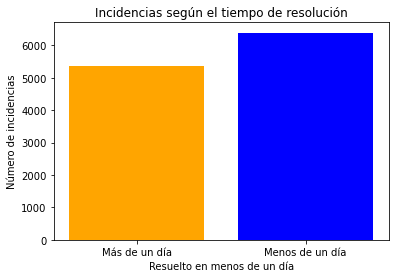

In [16]:
plt.bar(isOnTime_counts.index, isOnTime_counts.values, color=['blue', 'orange'])

# Añadir etiquetas y título
plt.xlabel('Resuelto en menos de un día')
plt.ylabel('Número de incidencias')
plt.title('Incidencias según el tiempo de resolución')

# Personalizar las etiquetas del eje x
plt.xticks(isOnTime_counts.index, ['Menos de un día', 'Más de un día'])

# Mostrar el gráfico
plt.show()

<AxesSubplot:ylabel='Is On Time'>

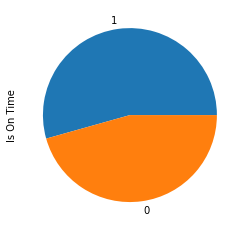

In [17]:
isOnTime_counts.plot.pie()

<Figure size 2160x720 with 0 Axes>

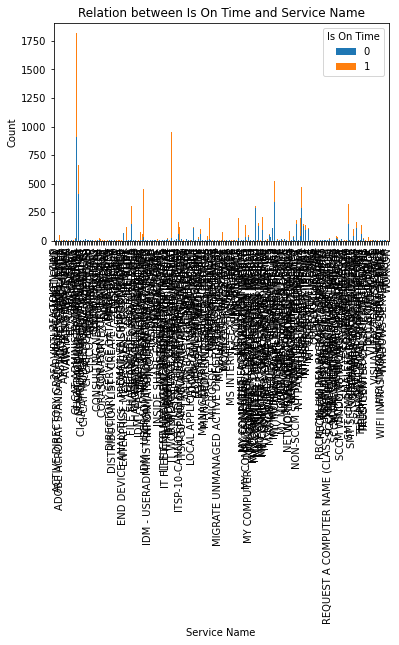

<Figure size 2160x720 with 0 Axes>

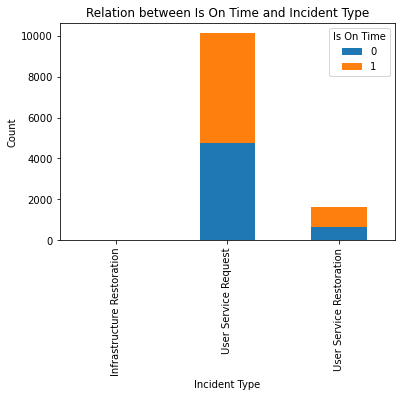

<Figure size 2160x720 with 0 Axes>

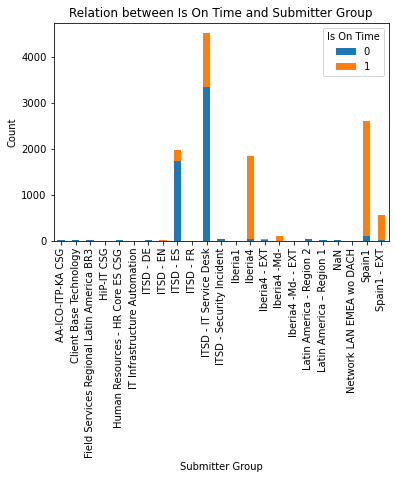

<Figure size 2160x720 with 0 Axes>

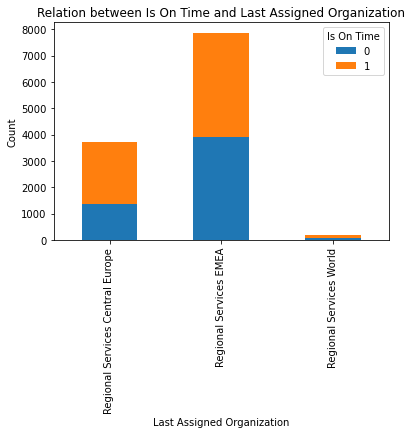

<Figure size 2160x720 with 0 Axes>

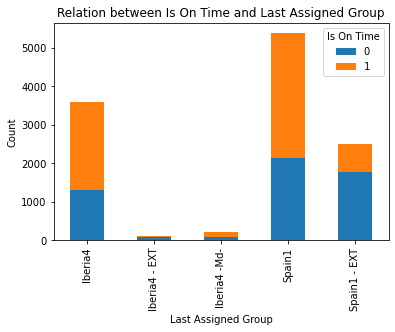

<Figure size 2160x720 with 0 Axes>

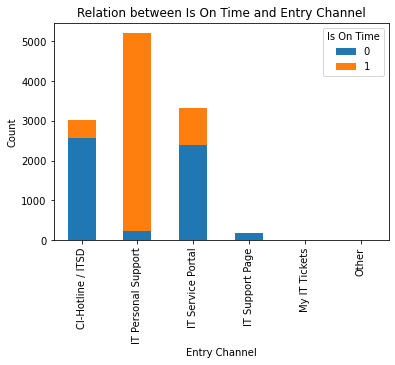

<Figure size 2160x720 with 0 Axes>

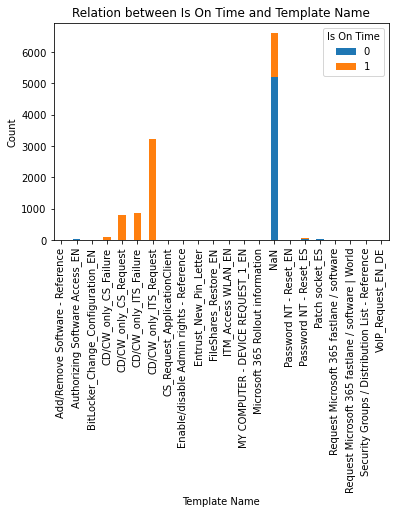

<Figure size 2160x720 with 0 Axes>

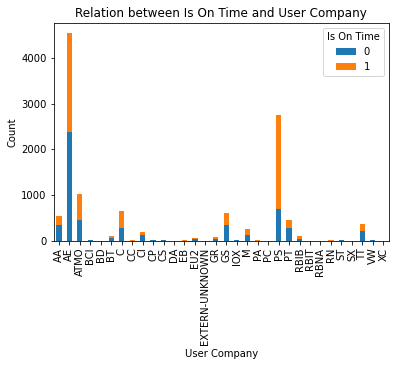

<Figure size 2160x720 with 0 Axes>

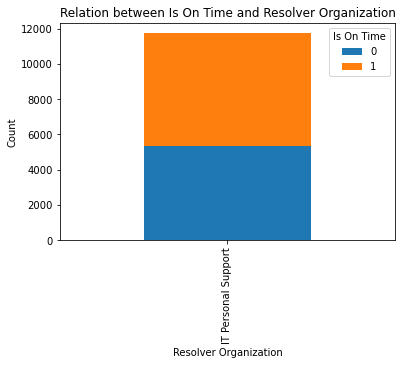

<Figure size 2160x720 with 0 Axes>

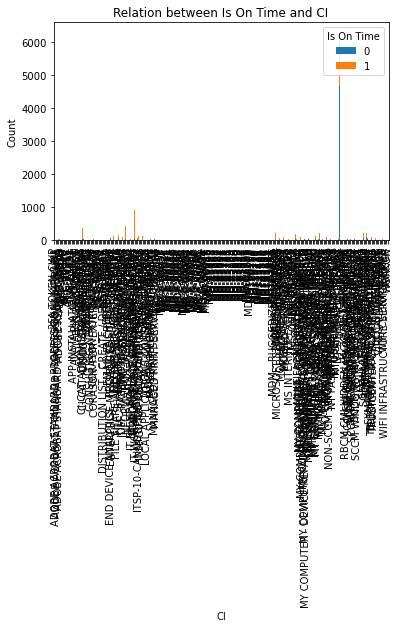

<Figure size 2160x720 with 0 Axes>

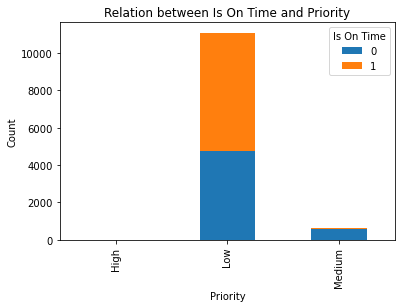

<Figure size 2160x720 with 0 Axes>

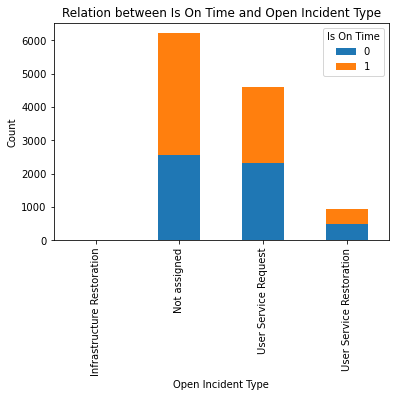

<Figure size 2160x720 with 0 Axes>

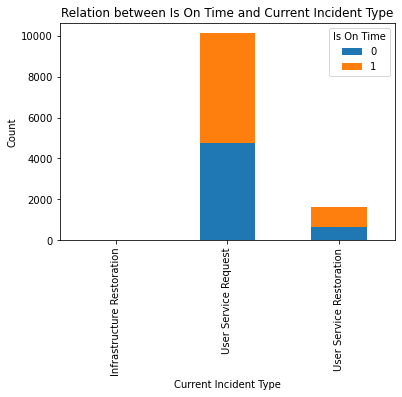

<Figure size 2160x720 with 0 Axes>

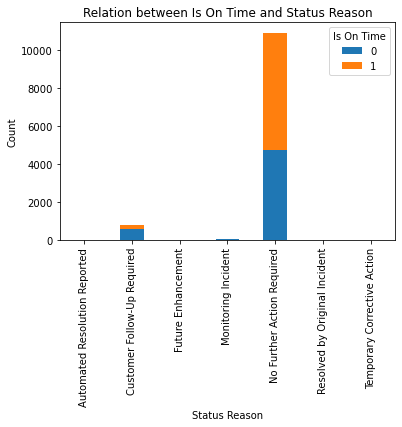

<Figure size 2160x720 with 0 Axes>

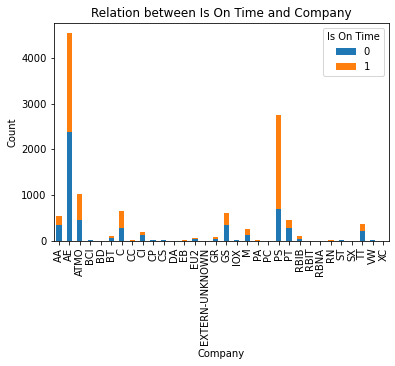

<Figure size 2160x720 with 0 Axes>

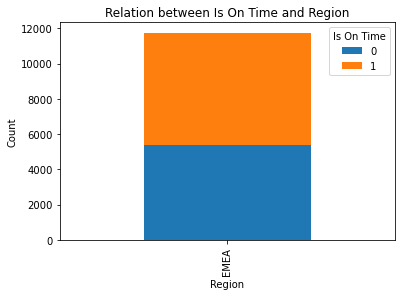

<Figure size 2160x720 with 0 Axes>

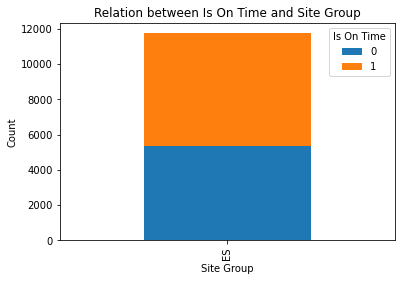

<Figure size 2160x720 with 0 Axes>

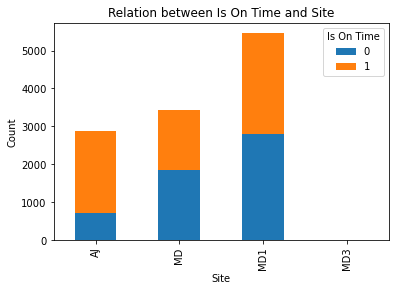

<Figure size 2160x720 with 0 Axes>

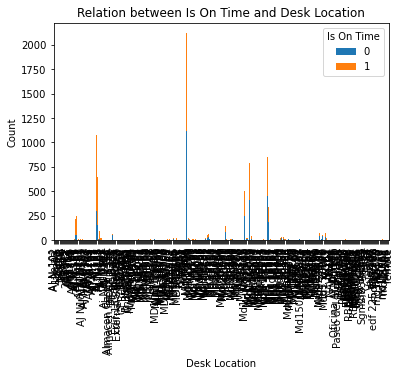

<Figure size 2160x720 with 0 Axes>

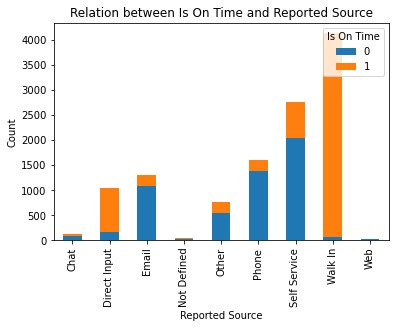

<Figure size 2160x720 with 0 Axes>

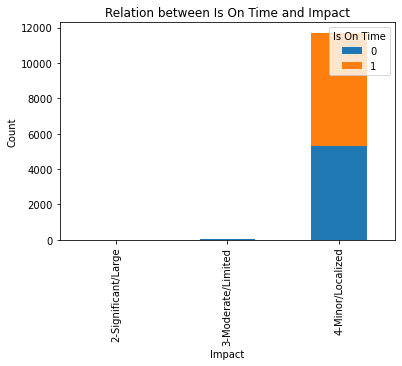

<Figure size 2160x720 with 0 Axes>

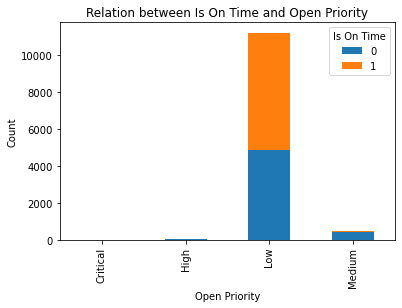

<Figure size 2160x720 with 0 Axes>

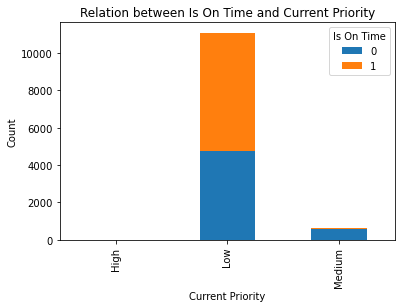

<Figure size 2160x720 with 0 Axes>

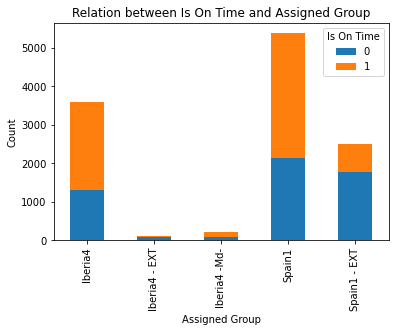

<Figure size 2160x720 with 0 Axes>

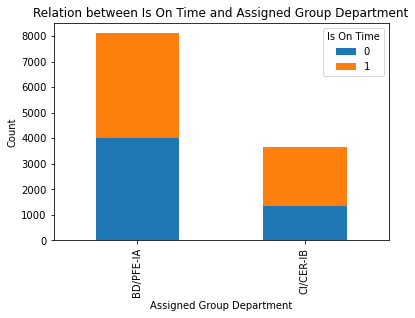

<Figure size 2160x720 with 0 Axes>

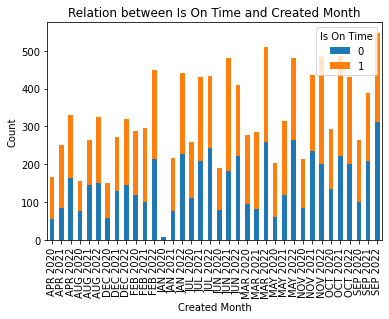

<Figure size 2160x720 with 0 Axes>

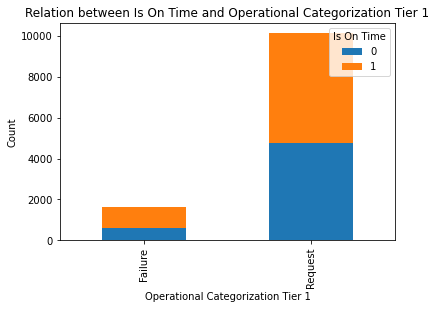

<Figure size 2160x720 with 0 Axes>

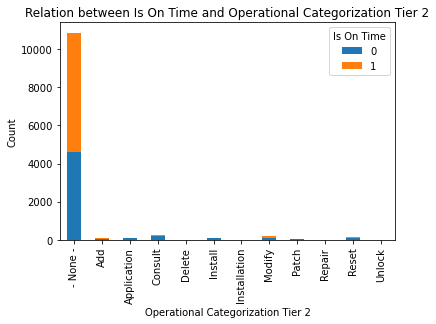

<Figure size 2160x720 with 0 Axes>

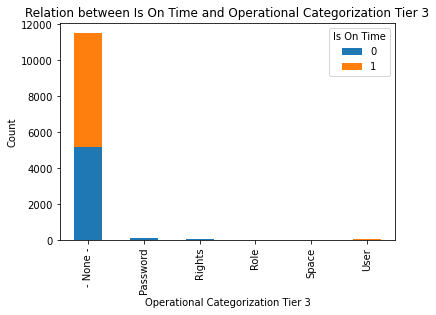

<Figure size 2160x720 with 0 Axes>

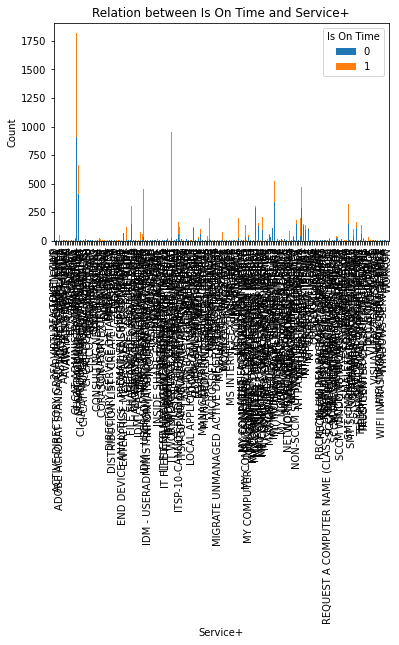

<Figure size 2160x720 with 0 Axes>

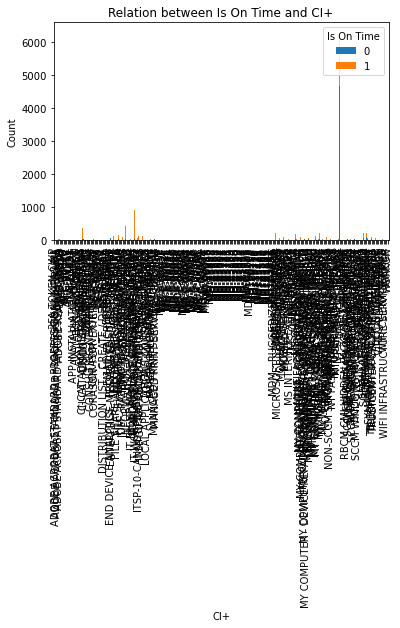

<Figure size 2160x720 with 0 Axes>

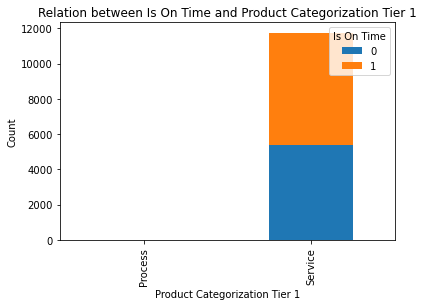

<Figure size 2160x720 with 0 Axes>

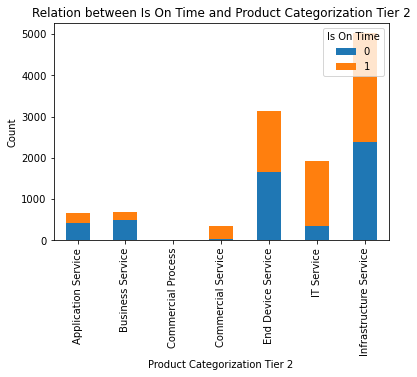

<Figure size 2160x720 with 0 Axes>

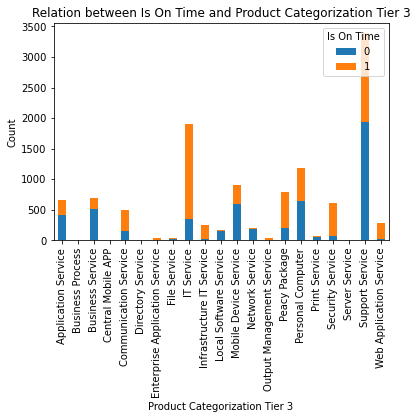

<Figure size 2160x720 with 0 Axes>

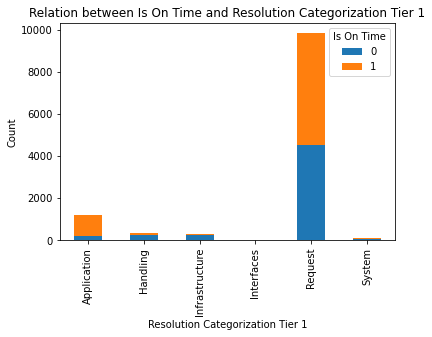

<Figure size 2160x720 with 0 Axes>

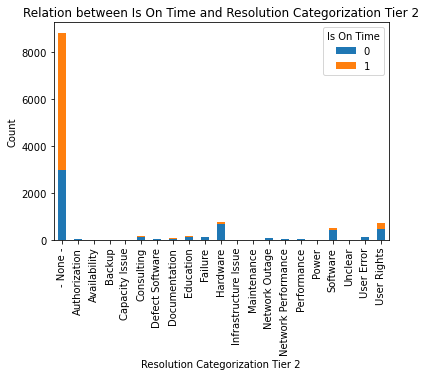

<Figure size 2160x720 with 0 Axes>

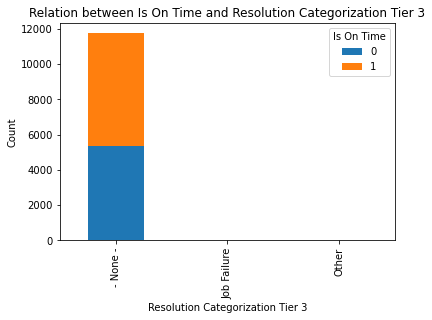

<Figure size 2160x720 with 0 Axes>

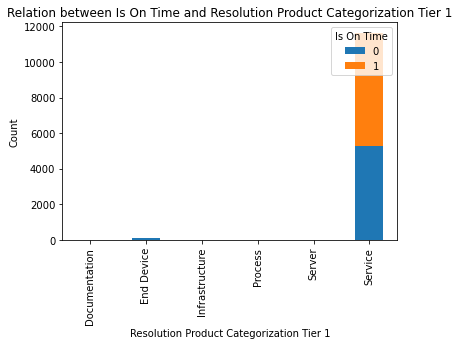

<Figure size 2160x720 with 0 Axes>

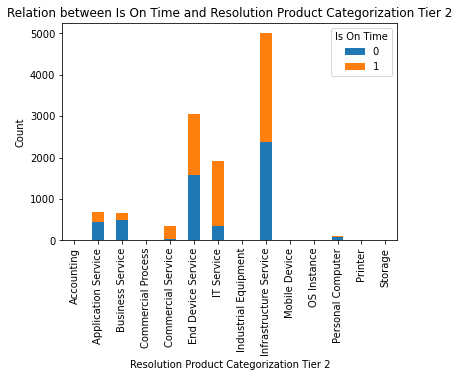

<Figure size 2160x720 with 0 Axes>

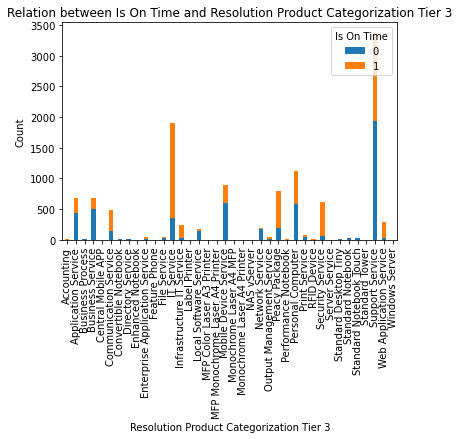

<Figure size 2160x720 with 0 Axes>

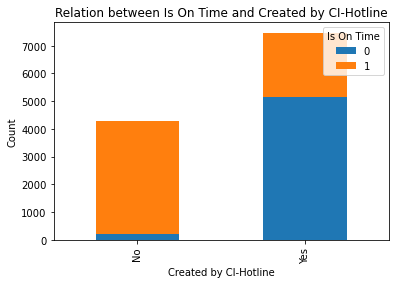

In [18]:
plot_df = combined_df.drop(['Incident Number'], axis=1)

features = plot_df.columns[plot_df.columns != 'Is On Time']

# Itera sobre las columnas y crea un gráfico por cada una
for feature in features:
    plt.figure(figsize=(30, 10))
    contingency_table = pd.crosstab(plot_df[feature], plot_df['Is On Time'])
    
    # Crea un gráfico de barras apiladas
    contingency_table.plot(kind='bar', stacked=True)
    
    plt.title(f'Relation between Is On Time and {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Is On Time', loc='upper right')
    plt.show()

In [18]:
columns_list = combined_df.columns
columns_list = [elem for elem in columns_list if elem not in ['Incident Number', 'Is On Time']] 
combined_df_one_hot = pd.get_dummies(combined_df, columns=columns_list)
combined_df_one_hot.shape

(11755, 1561)

In [19]:
combined_df_one_hot.rename(columns=lambda x: x.replace('.', ' '), inplace=True)
combined_df_one_hot.shape

(11755, 1561)

In [20]:
X = combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).values
y = combined_df_one_hot['Is On Time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [21]:
if (sklearn.__version__ < "1.1.0"):
    funcion_coste = 'log'
else:
    funcion_coste = 'log_loss'
funcion_coste

'log_loss'

Precisión (Acurracy) :  85.62%
Puntuación de validación cruzada(Cross Validation Score) con Train :  94.83%
Puntuación ROC_AUC :  85.08%


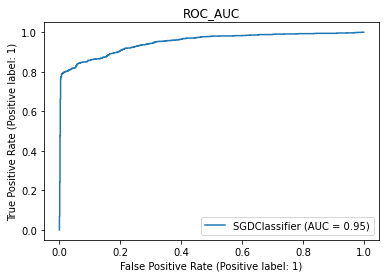

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1074
           1       0.84      0.91      0.87      1277

    accuracy                           0.86      2351
   macro avg       0.86      0.85      0.85      2351
weighted avg       0.86      0.86      0.86      2351



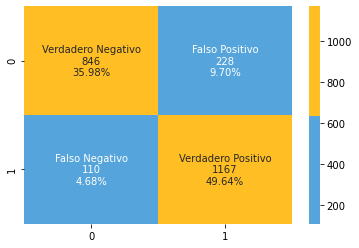

In [23]:
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


Precisión (Acurracy) :  88.64%
Puntuación ROC_AUC :  89.08%


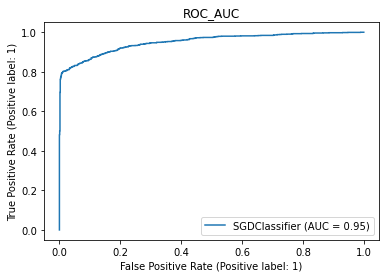

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1095
           1       0.95      0.83      0.89      1256

    accuracy                           0.89      2351
   macro avg       0.89      0.89      0.89      2351
weighted avg       0.90      0.89      0.89      2351



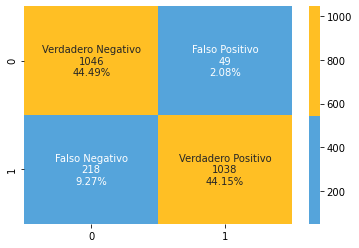

In [24]:
RANDOM_STATE = 9678
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, random_state=RANDOM_STATE)

log_classifier.fit(X_train, y_train)
prediction = log_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
#print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train,y_train, cv = cv ,scoring = 'roc_auc').mean()))
#print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_OH_sc,y_val_OH, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


In [25]:
X_test_df = pd.DataFrame(X_test, columns=combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).columns)
y_test_df = pd.DataFrame(y_test, columns=['Is On Time'])

y_test_df

,Is On Time
0,0
1,1
2,0
3,1
4,1
...,...
2346,1
2347,0
2348,1
2349,0


In [26]:
"""explainer = ClassifierExplainer(log_classifier, X_test_df, y_test_df)

ExplainerDashboard(explainer).run(port=8051)"""

'explainer = ClassifierExplainer(log_classifier, X_test_df, y_test_df)\n\nExplainerDashboard(explainer).run(port=8051)'

In [27]:
RANDOM_STATE = 123

Precisión (Acurracy) :  88.64%
Puntuación ROC_AUC :  89.35%


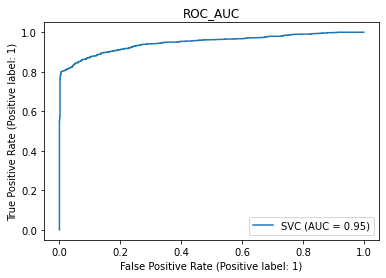

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      1074
           1       0.97      0.81      0.89      1277

    accuracy                           0.89      2351
   macro avg       0.89      0.89      0.89      2351
weighted avg       0.90      0.89      0.89      2351



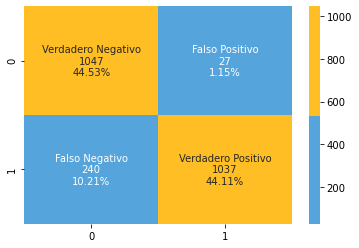

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

SVC_classifier = SVC(random_state=RANDOM_STATE)

SVC_classifier.fit(X_train, y_train)
prediction = SVC_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(SVC_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


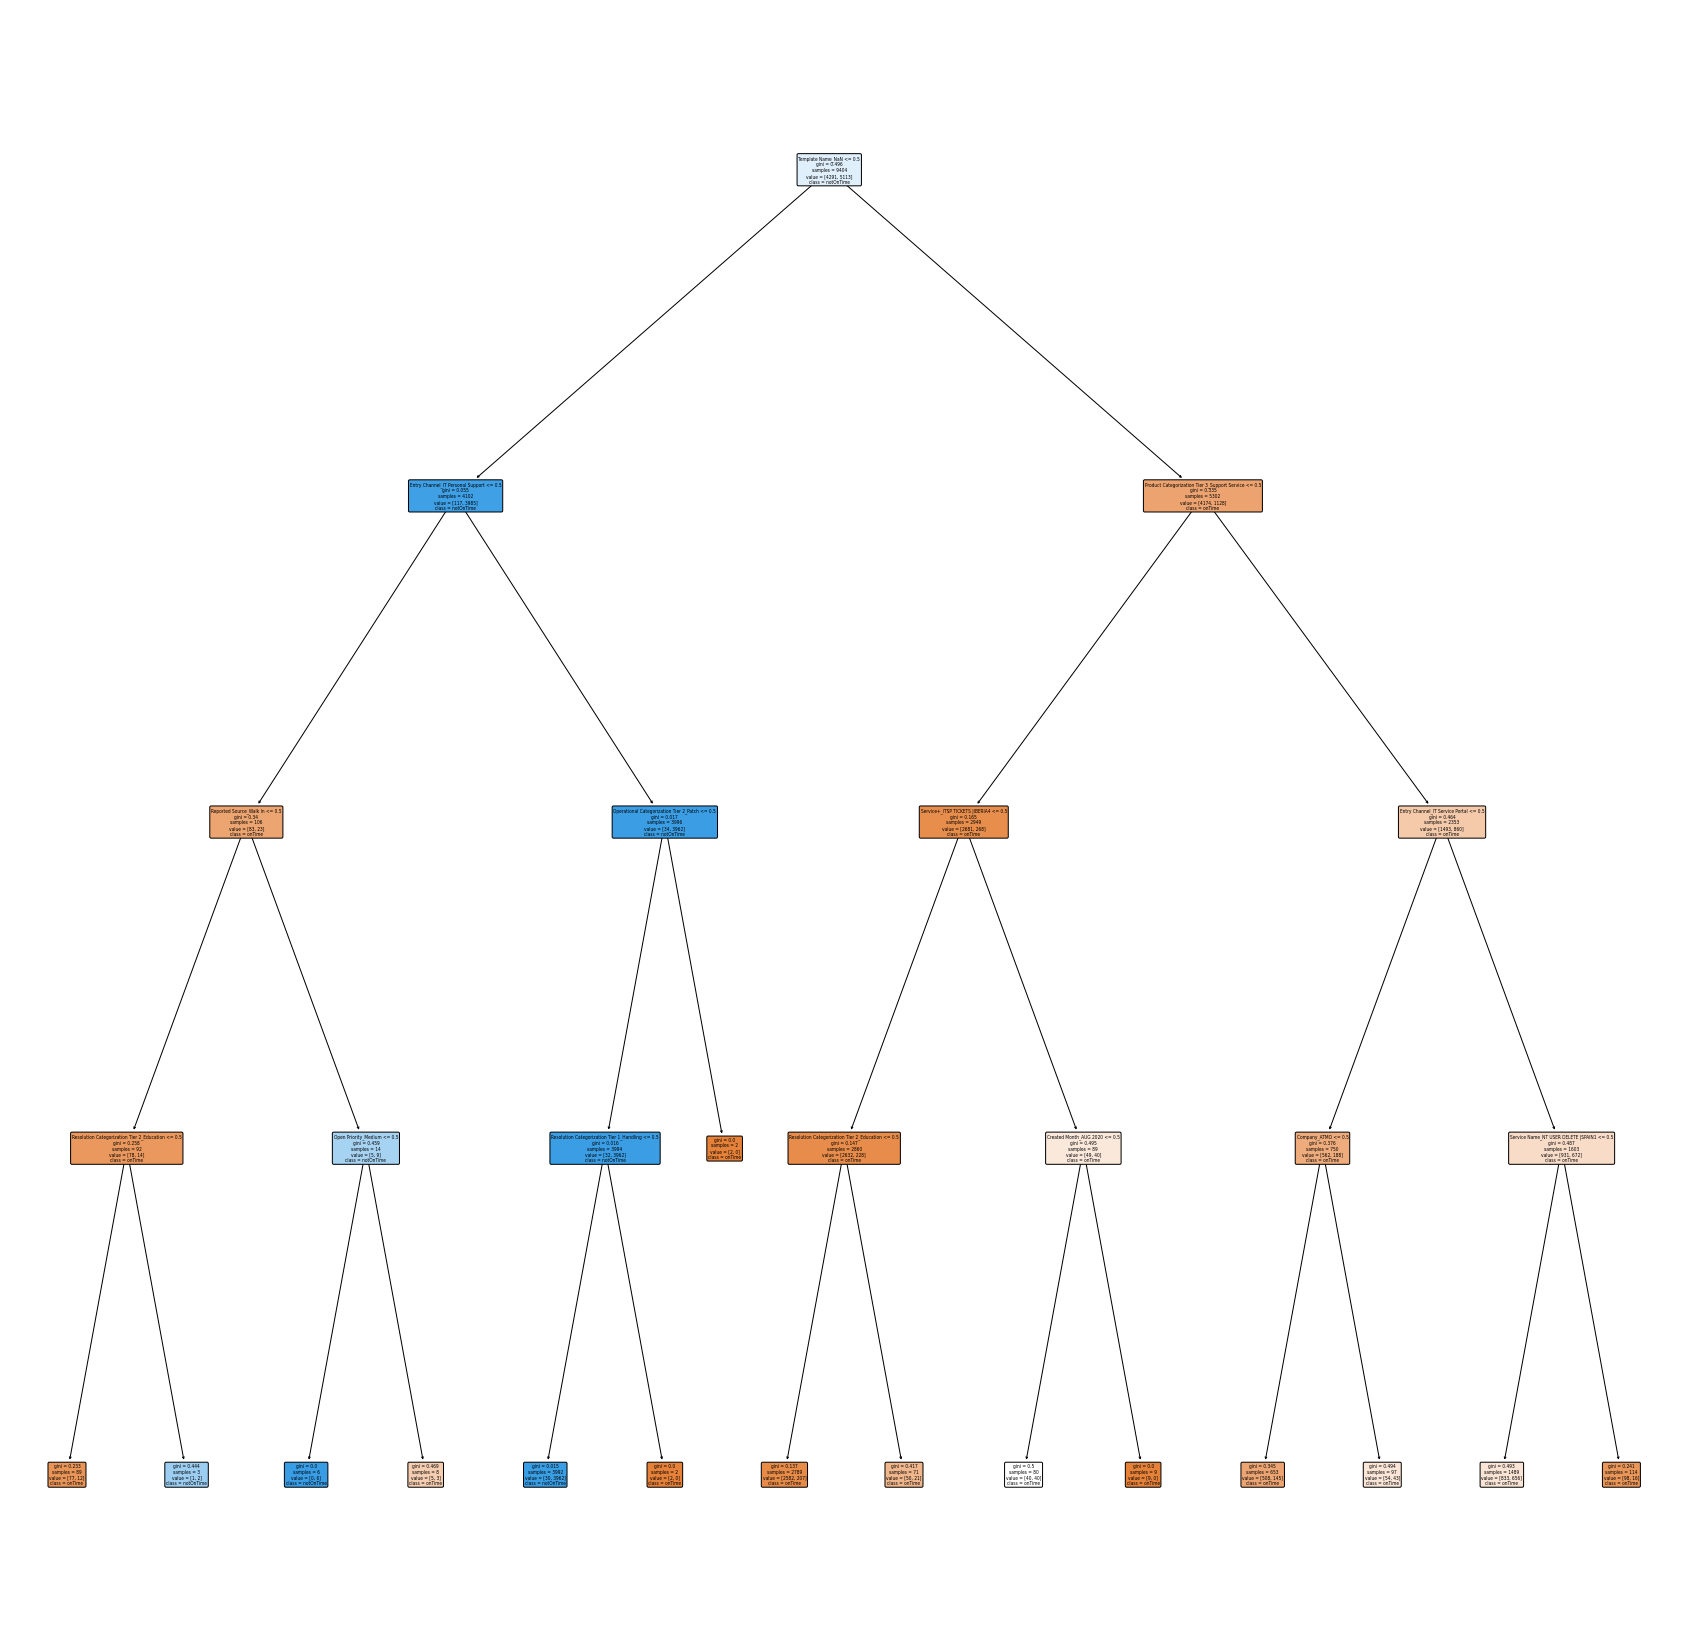

In [29]:
target_names = ['onTime', 'notOnTime']

tree_Clasifier = DecisionTreeClassifier(random_state = RANDOM_STATE, max_depth = 4)
tree_Clasifier.fit(X_train, y_train)
plt.figure(figsize=(30,30))
plot_tree(tree_Clasifier, filled = True, feature_names = combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).columns, class_names = target_names, rounded=True)
plt.show()

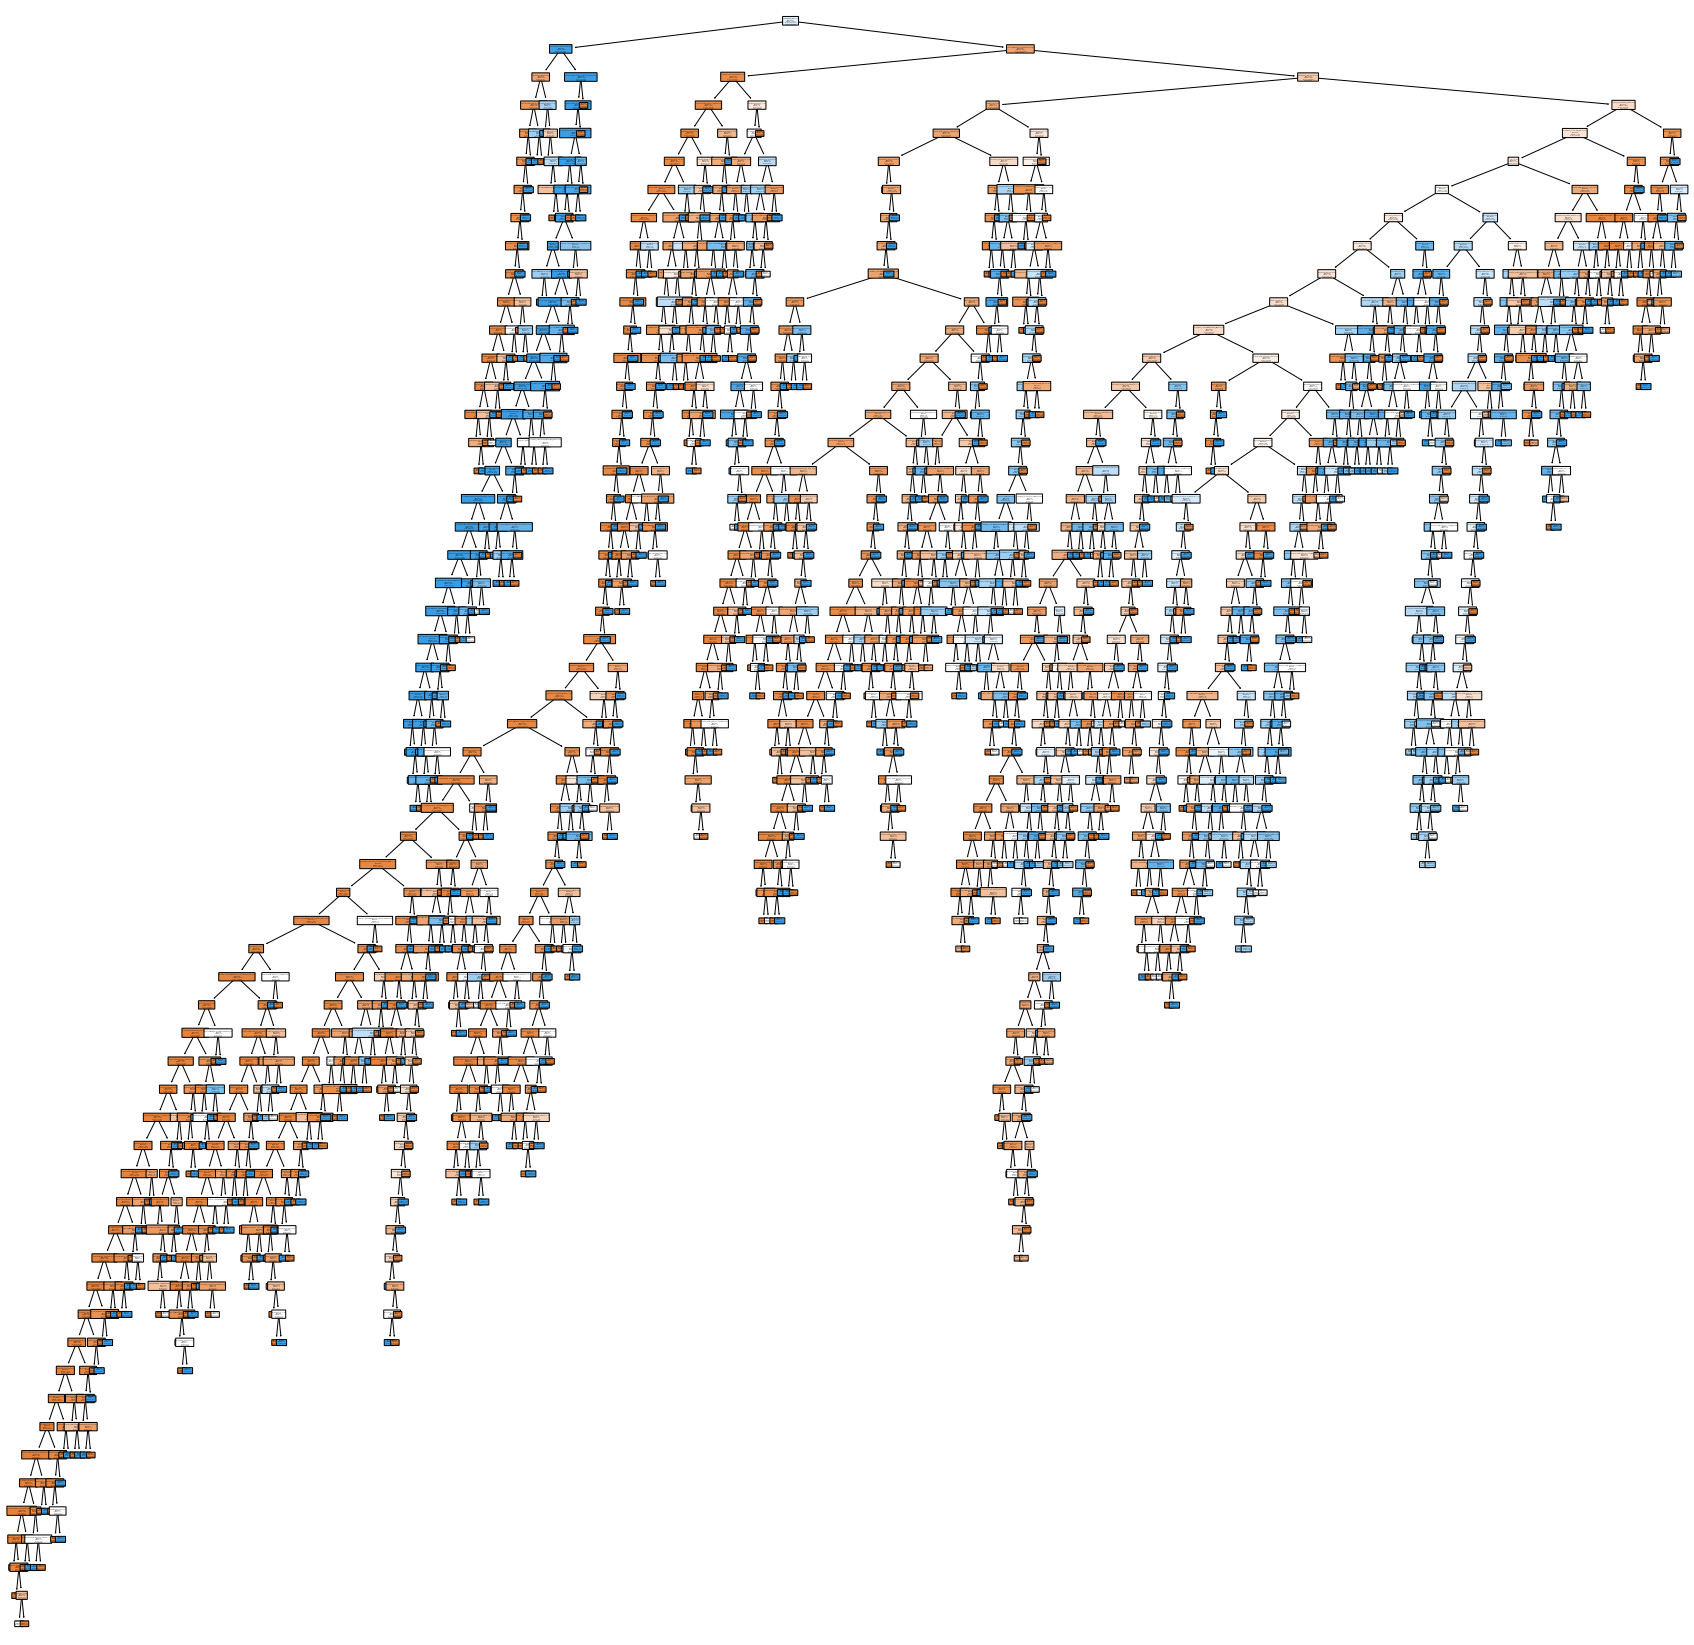

In [30]:
target_names = ['onTime', 'notOnTime']

tree_Clasifier = DecisionTreeClassifier(random_state = RANDOM_STATE)
tree_Clasifier.fit(X_train, y_train)
plt.figure(figsize=(30,30))
plot_tree(tree_Clasifier, filled = True, feature_names = combined_df_one_hot.drop(['Incident Number', 'Is On Time'], axis=1).columns, class_names = target_names, rounded=True)
plt.show()

In [31]:
tree_Clasifier.get_depth()

57

In [32]:
train_accuracy = tree_Clasifier.score(X_train, y_train)
test_accuracy = tree_Clasifier.score(X_test, y_test)
print("Precision en el aprendizaje:", train_accuracy)
print("Precision en el test:", test_accuracy)

Precision en el aprendizaje: 0.9814972352190557
Precision en el test: 0.874096129306678


Precisión (Acurracy) :  87.79%
Puntuación ROC_AUC :  88.61%


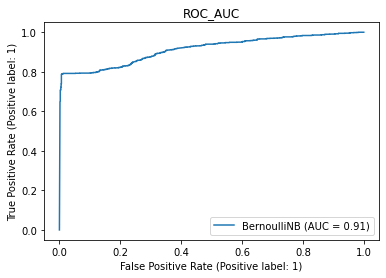

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1074
           1       0.98      0.79      0.88      1277

    accuracy                           0.88      2351
   macro avg       0.89      0.89      0.88      2351
weighted avg       0.90      0.88      0.88      2351



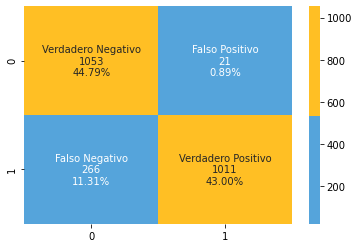

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

naiveBayes_classifier = BernoulliNB()

naiveBayes_classifier.fit(X_train, y_train)
prediction = naiveBayes_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(naiveBayes_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))


## Comparacion de precisiones

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

Random_states = [74563, 58941, 523, 2563, 45126, 69875, 1020, 36587, 9736520, 845699]
#Random_states = [684816, 649489, 149, 78844, 6548, 47411, 2151, 5461, 98498, 321665]
Random_states = [14586,484861,548,24154,1854796,8584,8798,45461,78556,1452,3651,1564468,87484,4843,74165,746168,7448654,4856,4968,6352]
sgd_accuracies = []
svc_accuracies = []
tree_accuracies = []
naive_accuracies = []
log_accuracies = []
knn_accuracies = []
rf_accuracies = []
gb_accuracies = []


In [79]:
for rand_state in Random_states:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    log_classifier_comp = LogisticRegression(random_state = rand_state, max_iter=400)
    log_classifier_comp.fit(X_train, y_train)
    log_accuracies.append(log_classifier_comp.score(X_test, y_test))

    sgd_classifier_comp = SGDClassifier(loss=funcion_coste, random_state=rand_state)
    sgd_classifier_comp.fit(X_train, y_train)
    sgd_accuracies.append(sgd_classifier_comp.score(X_test, y_test))

    knn_classifier_comp = KNeighborsClassifier()
    knn_classifier_comp.fit(X_train, y_train)
    knn_accuracies.append(knn_classifier_comp.score(X_test, y_test))

    tree_classifier_comp = DecisionTreeClassifier(random_state = rand_state)
    tree_classifier_comp.fit(X_train, y_train)
    tree_accuracies.append(tree_classifier_comp.score(X_test, y_test))

    rf_classifier_comp = RandomForestClassifier(random_state = rand_state)
    rf_classifier_comp.fit(X_train, y_train)
    rf_accuracies.append(rf_classifier_comp.score(X_test, y_test))

    gb_classifier_comp = GradientBoostingClassifier(random_state = rand_state)
    gb_classifier_comp.fit(X_train, y_train)
    gb_accuracies.append(gb_classifier_comp.score(X_test, y_test))

    svc_classifier_comp = SVC()
    svc_classifier_comp.fit(X_train, y_train)
    svc_accuracies.append(svc_classifier_comp.score(X_test, y_test))

    naive_classifier_comp = BernoulliNB()
    naive_classifier_comp.fit(X_train, y_train)
    naive_accuracies.append(naive_classifier_comp.score(X_test, y_test))

    print("Iteración completada")

Iteración completada


C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada


C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada


C:\Users\Dani\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Iteración completada
Iteración completada
Iteración completada
Iteración completada
Iteración completada


In [80]:
# Precisiones individuales
print("Precisiones de Logistic Regression: ", [round(x, 4) for x in log_accuracies])
print("Precisiones de SGD: ", [round(x, 4) for x in sgd_accuracies])
print("Precisiones de KNN: ", [round(x, 4) for x in knn_accuracies])
print("Precisiones de Decision Tree: ", [round(x, 4) for x in tree_accuracies])
print("Precisiones de Random Forest: ", [round(x, 4) for x in rf_accuracies])
print("Precisiones de Gradient Boosting: ", [round(x, 4) for x in gb_accuracies])
print("Precisiones de SVC: ", [round(x, 4) for x in svc_accuracies])
print("Precisiones de Naive Bayes: ", [round(x, 4) for x in naive_accuracies])

# Medias de precisiones
print("\n\nMedia de las precisiones de Logistic Regression: ", round(np.mean(log_accuracies), 4))
print("Media de las precisiones de SGD: ", round(np.mean(sgd_accuracies), 4))
print("Media de las precisiones de KNN: ", round(np.mean(knn_accuracies), 4))
print("Media de las precisiones de Decision Tree: ", round(np.mean(tree_accuracies), 4))
print("Media de las precisiones de Random Forest: ", round(np.mean(rf_accuracies), 4))
print("Media de las precisiones de Gradient Boosting: ", round(np.mean(gb_accuracies), 4))
print("Media de las precisiones de SVC: ", round(np.mean(svc_accuracies), 4))
print("Media de las precisiones de Naive Bayes: ", round(np.mean(naive_accuracies), 4))

Precisiones de Logistic Regression:  [0.8749, 0.8839, 0.8796, 0.8779, 0.8737, 0.8911, 0.8626, 0.8809, 0.8839, 0.8792, 0.8792, 0.8805, 0.8852, 0.8877, 0.889, 0.8762, 0.8707, 0.8728, 0.8732, 0.8758]
Precisiones de SGD:  [0.8724, 0.8754, 0.8809, 0.8783, 0.8783, 0.8886, 0.8622, 0.8745, 0.8728, 0.8809, 0.8681, 0.8839, 0.8792, 0.8839, 0.883, 0.8711, 0.8715, 0.8622, 0.8588, 0.8707]
Precisiones de KNN:  [0.8745, 0.8864, 0.8966, 0.8783, 0.8856, 0.886, 0.8745, 0.8792, 0.8835, 0.8852, 0.8805, 0.8852, 0.8822, 0.8886, 0.8839, 0.8741, 0.8775, 0.8754, 0.8741, 0.8741]
Precisiones de Decision Tree:  [0.8618, 0.8809, 0.8843, 0.8715, 0.8728, 0.8732, 0.8537, 0.8703, 0.8711, 0.8771, 0.8749, 0.8766, 0.8779, 0.8754, 0.8788, 0.8745, 0.8724, 0.8622, 0.8711, 0.872]
Precisiones de Random Forest:  [0.8835, 0.8996, 0.9022, 0.8945, 0.9009, 0.8979, 0.8843, 0.8949, 0.8954, 0.8924, 0.8894, 0.9013, 0.9, 0.9026, 0.8992, 0.8945, 0.8932, 0.8898, 0.8954, 0.889]
Precisiones de Gradient Boosting:  [0.8766, 0.8856, 0.8801, 0.

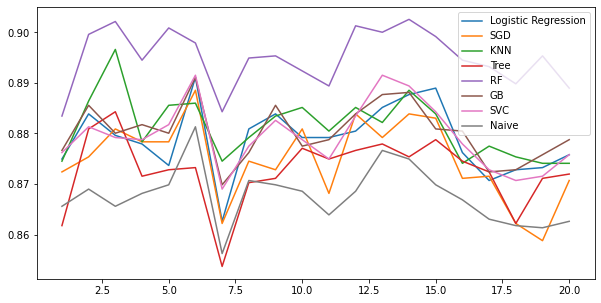

In [83]:
#Plot que te muestra la precisión de cada modelo en cada iteración
plt.figure(figsize=(10, 5))
plt.plot(range(1,21), log_accuracies, label='Logistic Regression')
plt.plot(range(1,21), sgd_accuracies, label='SGD')
plt.plot(range(1,21), knn_accuracies, label='KNN')
plt.plot(range(1,21), tree_accuracies, label='Tree')
plt.plot(range(1,21), rf_accuracies, label='RF')
plt.plot(range(1,21), gb_accuracies, label='GB')
plt.plot(range(1,21), svc_accuracies, label='SVC')
plt.plot(range(1,21), naive_accuracies, label='Naive')
plt.legend()
plt.show()

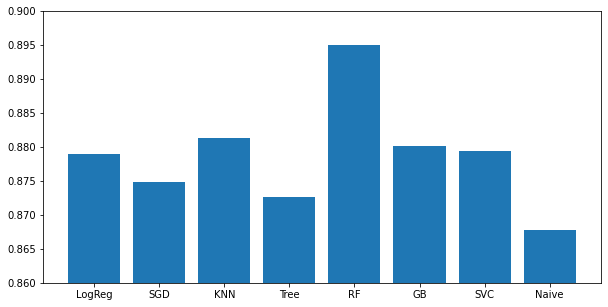

In [84]:
#Plot que te muestra la precisión media de cada modelo
plt.figure(figsize=(10, 5))
plt.bar(['LogReg', 'SGD', 'KNN', 'Tree', 'RF', 'GB', 'SVC', 'Naive'], [np.mean(log_accuracies), np.mean(sgd_accuracies), np.mean(knn_accuracies), np.mean(tree_accuracies), np.mean(rf_accuracies), np.mean(gb_accuracies), np.mean(svc_accuracies), np.mean(naive_accuracies)])
plt.ylim(0.86, 0.9)
plt.show()


In [35]:
RANDOM_STATE = 3572

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_classifier_comp = RandomForestClassifier(random_state = RANDOM_STATE)
rf_classifier_comp.fit(X_train, y_train)
rf_classifier_comp.score(X_test, y_test)


0.8987664823479371

Precisión (Acurracy) :  89.88%
Puntuación ROC_AUC :  90.05%


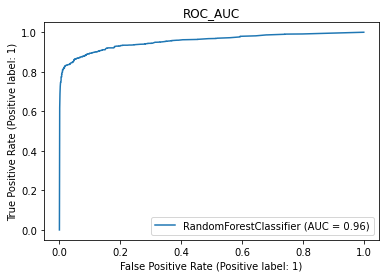

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1085
           1       0.93      0.88      0.90      1266

    accuracy                           0.90      2351
   macro avg       0.90      0.90      0.90      2351
weighted avg       0.90      0.90      0.90      2351



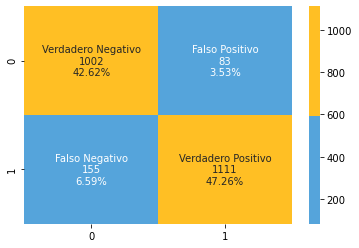

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_classifier = RandomForestClassifier(random_state = RANDOM_STATE)

rf_classifier.fit(X_train, y_train)
prediction = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(rf_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))

In [39]:
#Hiperparámetros para Random Forest

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
criterion = ['gini', 'entropy', 'log_loss']

n_estimators

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [19]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, None]
}

RF_gridSearch = RandomForestClassifier()
grid_search = GridSearchCV(estimator = RF_gridSearch, param_grid = param_grid)

TypeError: __init__() got an unexpected keyword argument 'param_grid'

La siguiente celda estuvo más de 300 minutos por lo que GridSearchCV no es factible. Hay que aplicar RandomSearchCV

In [46]:
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=3,
                       min_samples_split=8)
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [30]:
RANDOM_STATE = 123

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [100, 200, 500, 1000, 2000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, 200, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid)

In [31]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [100, 200, 500, 1000]})

In [32]:
print(randomized_search.best_estimator_)
print(randomized_search.best_params_)

RandomForestClassifier(max_depth=50, n_estimators=500)
{'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini'}


In [41]:
RANDOM_STATE = 3572

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, 200, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid)

In [42]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 50, 100, 200, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [43]:
print(randomized_search.best_estimator_)
print(randomized_search.best_params_)

RandomForestClassifier(max_depth=200, n_estimators=1800)
{'n_estimators': 1800, 'max_features': 'sqrt', 'max_depth': 200, 'criterion': 'gini'}


In [63]:
RANDOM_STATE = 3572

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 4000, num = 20)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 50, 100, 200, 300, 400, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid)

In [64]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 50, 100, 200, 300,
                                                      400, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000, 2200, 2400,
                                                         2600, 2800, 3000, 3200,
                                                         3400, 3600, 3800,
                                                         4000]})

In [65]:
print(randomized_search.best_estimator_)
print(randomized_search.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=400)
{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}


In [22]:
RANDOM_STATE = 3572

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 4000, num = 20)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [50, 100, 200, 300, 400, 500, None]
}

RF_randomizedSearch = RandomForestClassifier()
randomized_search = RandomizedSearchCV(RF_randomizedSearch, param_grid)

In [23]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [50, 100, 200, 300, 400,
                                                      500, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000, 2200, 2400,
                                                         2600, 2800, 3000, 3200,
                                                         3400, 3600, 3800,
                                                         4000]})

In [24]:
print(randomized_search.best_estimator_)
print(randomized_search.best_params_)

RandomForestClassifier(criterion='log_loss', max_depth=100, max_features=None,
                       n_estimators=400)
{'n_estimators': 400, 'max_features': None, 'max_depth': 100, 'criterion': 'log_loss'}


Precisión (Acurracy) :  90.00%
Puntuación ROC_AUC :  90.18%


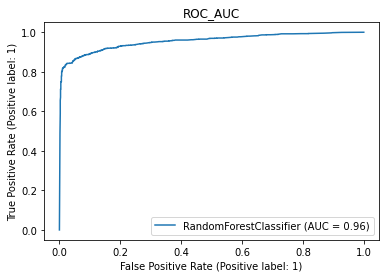

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1085
           1       0.93      0.88      0.90      1266

    accuracy                           0.90      2351
   macro avg       0.90      0.90      0.90      2351
weighted avg       0.90      0.90      0.90      2351



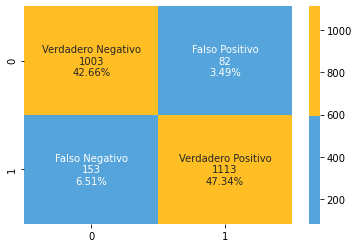

In [66]:
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt', n_estimators=400, random_state=RANDOM_STATE)

rf_classifier.fit(X_train, y_train)
prediction = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

RocCurveDisplay.from_estimator(rf_classifier, X_test,y_test)
plt.title('ROC_AUC')
plt.show()

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(y_test, prediction)
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(y_test, prediction))